# Feasible Region Representation

Below are useful functions for drawing polygons in 3 dimensions. In addition to this, there is an example for polygons in 2D and 3D.

# Functions for drawing

In [31]:
import numpy as np
from sympy import Plane, Point3D
import networkx as nx
import itertools

from matplotlib.patches import Circle
from scipy.optimize import linprog
from scipy.spatial import HalfspaceIntersection
from scipy.spatial import ConvexHull
import scipy as sp
from itertools import combinations
from IPython.display import display
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as a3
import matplotlib.colors as colors

%matplotlib inline

import matplotlib as mpl

In [32]:
def simplify(triangles):

    # create a graph in which nodes represent triangles;
    # nodes are connected if the corresponding triangles are adjacent and coplanar
    G = nx.Graph()
    G.add_nodes_from(range(len(triangles)))
    for ii, a in enumerate(triangles):
        for jj, b in enumerate(triangles):
            if (ii < jj): # test relationships only in one way as adjacency and co-planarity are bijective
                if is_adjacent(a, b):
                    if is_coplanar(a, b, np.pi / 180.):
                        G.add_edge(ii,jj)
    # flatten function
    flatten = lambda l: [item for sublist in l for item in sublist]

    # triangles that belong to a connected component can be combined
    components = list(nx.connected_components(G))
    simplified = [set(flatten(triangles[index] for index in component)) for component in components]

    # need to reorder nodes so that patches are plotted correctly
    reordered = [list(reorder(face)) for face in simplified]

    return reordered


def is_adjacent(a, b):
    return len(set(a) & set(b)) == 2 # i.e. triangles share 2 points and hence a side


def is_coplanar(a, b, tolerance_in_radians=0):
    a1, a2, a3 = a
    b1, b2, b3 = b
    plane_a = Plane(Point3D(a1), Point3D(a2), Point3D(a3))
    plane_b = Plane(Point3D(b1), Point3D(b2), Point3D(b3))
    if not tolerance_in_radians: # only accept exact results
        return plane_a.is_coplanar(plane_b)
    else:
        angle = plane_a.angle_between(plane_b).evalf()
        angle %= np.pi # make sure that angle is between 0 and np.pi
        return (angle - tolerance_in_radians <= 0.) or \
            ((np.pi - angle) - tolerance_in_radians <= 0.)


def reorder(vertices):
    # Reorders nodes so they form a face
    # Tolerance to error in degree angle
    tolerance = 0.05
    
    if len(vertices) <= 3: # just a triangle
        return vertices
    else:
        vertices = list(vertices)
        combinations = get_combinations(len(vertices))
        angle = 180*(len(vertices)-2) 
        
        for comb in combinations:
            
            reordered = [vertices[c] for c in comb]
            inner_angle = get_innerAngle(reordered)
            
            if (inner_angle < angle + tolerance) and (inner_angle > angle - tolerance):
                return reordered
            

def get_combinations(n):
    stuff = range(n)
    out = []
    for L in range(0, len(stuff)+1):
        for subset in itertools.permutations(stuff, L):
            if (len(subset) == len(stuff)) and (subset[0] == stuff[0]):
                out.append(subset)
    
    return(out)
    
def get_angle3D(a,b,c):
    ba = np.array(a) - np.array(b)
    bc = np.array(c) - np.array(b)
    
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)

    return np.degrees(angle)

def get_innerAngle(vertices):
    tmp = vertices.copy()
    # Add information to do calculations
    tmp = [tmp[-1]] + tmp + [tmp[0]]
    
    angle = 0
    
    for i in range(1,len(tmp)-1):
        angle += get_angle3D(tmp[i-1],tmp[i],tmp[i+1])
    
    return angle
    

def get_distance(v1, v2):
    v2 = np.array(list(v2))
    difference = v2 - v1
    ssd = np.sum(difference**2, axis=1)
    return np.sqrt(ssd)

def polygon3D(halfspaces, feasible_point, options):
    
    hs = HalfspaceIntersection(halfspaces, feasible_point)
    verts = hs.intersections
    hull = ConvexHull(verts)
    faces = hull.simplices
    
    triangles = []
    for s in faces:
        sq = [
            (verts[s[0], 0], verts[s[0], 1], verts[s[0], 2]),
            (verts[s[1], 0], verts[s[1], 1], verts[s[1], 2]),
            (verts[s[2], 0], verts[s[2], 1], verts[s[2], 2])
        ]
        triangles.append(sq)
    
    new_faces = simplify(triangles)
    
    # Create Figure
    ax = a3.Axes3D(plt.figure())

    ax.dist= options['distance']
    ax.azim= options['assymetry']
    ax.elev= options['elevation']
    
    for sq in new_faces:
        f = a3.art3d.Poly3DCollection([sq])
        f.set_color(colors.rgb2hex(sp.rand(3)))
        f.set_edgecolor('k')
        f.set_alpha(0.4)
        ax.add_collection3d(f)
        
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title(options['title'])
    
    xpoints = [it[0] for it in verts]
    ypoints = [it[1] for it in verts]
    zpoints = [it[2] for it in verts]

    
    scale = np.max([np.max(xpoints),np.max(ypoints),np.max(zpoints)])/15
    
    ax.set_xlim(np.min(xpoints) - scale/2, np.max(xpoints) + scale)
    ax.set_ylim(np.min(ypoints) - scale/2, np.max(ypoints) + scale)
    ax.set_zlim(np.min(zpoints) - scale/2, np.max(zpoints) + scale)
                
    return ax

def polygon2D(vertices, options):
    
    path_points = reorder(vertices)
    path_points = list(path_points) + list([path_points[0]])

    # Draw from points
    path = mpl.path.Path(path_points)            
    patch = mpl.patches.PathPatch(path, facecolor= options['color'])               
    # Add to plot
    plt.gca().add_patch(patch)

    plt.xlabel('x')
    plt.ylabel('y')

    xpoints = [it[0] for it in path_points]
    ypoints = [it[1] for it in path_points]

    scale = np.max([np.max(xpoints),np.max(ypoints)])/15

    plt.xlim(np.min(xpoints) - scale/2, np.max(xpoints) + scale)
    plt.ylim(np.min(ypoints) - scale/2, np.max(ypoints) + scale)

    plt.gca().set_aspect('equal', adjustable='box')

    ax = plt.gca()
    ax.set_title(options['title'])

    return ax

### The following is the definition of the function that finds the basic solutions of an optimization problem in standard form.

In [33]:
def func(A, b):
    
    # Create a dictionary with both keys and values being empty lists.
    dir = {'Solution': [], 'Base': []}
    
    # Determine the dimension of the input matrix and vector.
    sizeA = np.shape(A) # m equations
    sizeb = np.shape(b) # n unknowns
    
    # Use the combinations function to find all possible combinations that can be made
    # with the m equations and n unknowns. The components of each tuple returned by the function indicate which
    # columns of the matrix are eliminated, i.e., which variables are set to zero to solve the
    # resulting system of equations. The number of resulting combinations is the number of basic solutions
    # that the optimization problem has.
    combs = combinations(list(range(0, sizeA[1])), (sizeA[1] - sizeA[0]))
    
    # We are going to examine all possible combinations of variables set to zero.
    for item in list(combs):
        
        # Create a copy of the matrix, called A_1
        A_1 = A.copy()
        
        # The item-th (tuple numbers) columns (indicated by axis=1) of A_1 are deleted, i.e., the
        # variables corresponding to those columns are set to zero.
        A_1 = np.delete(A_1, item, axis=1)
        
        # Create another copy of the matrix, called A_2
        A_2 = A.copy()
        
        # The item-th (tuple numbers) columns of A_2 are set to zero to indicate how the system looks when
        # those variables are set to zero. These are the bases corresponding to each basic solution.
        A_2[:, item] = 0
        
        # The basic solution is given by the solution of the resulting system when setting the m-n variables to zero.
        # If the matrix of the resulting system of equations is singular, the word 'Singular' is added to the keys, and its
        # respective base to the values.
        if (np.linalg.det(A_1) == 0):
            dir['Solution'].append('Singular Matrix')
            dir['Base'].append(A_2)
        # If the matrix can be inverted, the basic solution is found without any problem. After finding these values,
        # the columns that were previously deleted are added again, and a zero is added in the item-th
        # component of each basic solution.
        else:
            ans = np.dot(np.linalg.inv(A_1), b)
            ans = np.round(ans, 3)
            # This loop is used to iterate over the item-th components of the basic solutions (those that were
            # previously deleted). A zero is added in each component.
            for i in item:
                ans = np.insert(ans, i, 0, axis=0)
            # The basic solutions are added to the 'Solution' key of the dictionary, and the resulting matrices to the 'Base' value.
            dir['Solution'].append(ans)
            dir['Base'].append(A_2)
             
                               
    return dir


### The following is the implementation of the function that determines the feasible basic solutions of an optimization problem in standard form, based on the basic solutions.

In [34]:
def fun(A, b):
    
    # Create a dictionary with two keys. The values of the 'Feasible' key correspond to the feasible basic solutions.
    # The values of the 'Base' key correspond to the bases corresponding to the feasible basic solutions.
    feasible = {'Feasible': [], 'Base': []}
    
    # Call the previously created function to determine the basic solutions.
    res1 = func(A, b)
    
    # The basic solutions correspond to the values of the 'Solution' key of the dictionary returned by the function
    # from point 1. The bases of these basic solutions correspond to the values of the 'Base' key of the dictionary 
    # returned by the function from point 1.
    basic_solutions = res1['Solution']
    bases_basic_solutions = res1['Base']

    # Feasible basic solutions correspond to the values of the 'Solution' key of the previously created dictionary.
    # The bases of these feasible basic solutions correspond to the values of the 'Base' key of the previously created dictionary.
    feasible_basic_solutions = feasible['Feasible']
    bases_feasible_basic_solutions = feasible['Base']
       
    # Iterate over all basic solutions. If all components of the vector corresponding to a basic solution
    # are greater than or equal to zero, this solution is basic and therefore the value of this basic solution is added to the
    # dictionary of feasible basic solutions. Similarly, the value of the base corresponding to that
    # basic solution is added to the dictionary.
    for solution in basic_solutions:
        if solution == 'Singular Matrix':
            pass
        else:
            if all(x >= 0 for x in solution):
                feasible['Feasible'].append(solution)
                feasible['Base'].append(res1.get('Base', solution))
            else:
                pass
            
    # Present the information obtained by the function in an ordered table using the pandas library.
    table1 = pd.DataFrame({
        'Solution': feasible_basic_solutions,
        'Base': bases_feasible_basic_solutions
    })

    display(table1)
    
    return feasible

# 1) Definition of a function that plots the feasible region of an optimization problem in standard form.

In [35]:
def genFeasibleRegion(halfspaces):
    
    # Get the dimension of the halfspaces matrix.
    sizeA = np.shape(halfspaces)
    
    # Concatenate the submatrix halfspaces without the last column with the slack variable vectors, represented by 
    # an identity matrix with the same number of rows as the halfspaces matrix.
    A = np.concatenate((halfspaces[:,:-1], np.identity(halfspaces.shape[0])), axis=1)
    
    # The vector b is given by the negative of the last column of the halfspaces matrix.
    b = -1 * halfspaces[:, -1]
    
    # Find the feasible basic solutions of the optimization problem.
    feasible = fun(A, b)
    
    # Create an empty list to later fill it with the feasible basic solutions of the problem. These feasible basic solutions
    # correspond to the vertices of the polygon generated by the intersection of the halfspaces.
    vertices = []
    
    # If the optimization problem has less than 3 variables (4 dimensions as defined in the halfspaces matrix), 
    # the drawing procedure is carried out with the polygon2D function.
    if sizeA[1] < 4:

        # Iterate over the list of feasible basic solutions, and each element of the list is added to the list of vertices.
        # Only the first two elements of the feasible basic solutions vector are added, which correspond to the decision
        # variables, not the slack variables.
        for item in list(feasible['Feasible']):
            lista = list(item)
            vertices.append(lista[:2])

        # Options for color, labels, and title of the generated plot.
        options = {'color': 'lightblue',
                   'xlabel': 'x' ,
                   'ylabel': 'y',
                   'title':'Feasible Region'}

        # Draw the feasible region from the feasible basic solutions.
        ax = polygon2D(vertices, options)

        # Mark each feasible basic solution with a red point.
        for item in vertices:
            ax.scatter(item[0], item[1], c='red', marker='.', s=180)
    
    # If the optimization problem has exactly 3 variables (4 dimensions as defined in the halfspaces matrix),
    # the drawing procedure is carried out with the polygon3D function.
    elif sizeA[1] == 4:
        
        # Iterate over the list of feasible basic solutions, and each element of the list is added to the list of vertices.
        # Only the first three elements of the feasible basic solutions vector are added, which correspond to the decision
        # variables, not the slack variables.
        for item in list(feasible['Feasible']):
            lista = list(item)
            vertices.append(lista[:3])
        
        # To be able to plot in three dimensions, 3 rows must be added to the halfspaces matrix,
        # corresponding to the slack variables. 
        halfspaces3d = np.append(halfspaces, [[-1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0]], axis=0)
        
        # Options for 3D plotting
        options = {'distance': 10,
                   'assymetry': 10,
                   'elevation': 10,
                   'title': 'Feasible Region'}

        # A point inside the feasible region is also needed. This point will be requested as user input.
        feasible_point = []
        
        # If the point selected by the user is inside the feasible region and the point consists of only 3
        # coordinates, the feasible region can be drawn.
        try:
            feasible_point = [float(item) for item in input("Enter the x, y, z coordinates (in that order) of the point inside the feasible region separated by spaces: ").split()] 

            feasible_point = np.asarray(feasible_point) 

            # Draw the feasible region from the feasible basic solutions.
            ax = polygon3D(halfspaces3d, feasible_point, options)

            # Mark each feasible basic solution with a red point.
            for item in vertices:
                ax.scatter(item[0], item[1], item[2], c='red', marker='.', s=180)
                
        # If the point selected by the user is not inside the feasible region or the user did not write the
        # point inside the feasible region correctly, an error is shown.
        except:
            print("One of these four happened: \n 1. The point is not inside the feasible region \n 2. More than three coordinates were written \n 3. Numbers were not written \n 4. Not separated by spaces ")
            

**IMPORTANT**: Keep in mind that for the function to deliver correct results, the half-spaces must be declared in the form $$Ax \leq -b$$

Information on how to get a list as input from the user can be found [here](https://www.geeksforgeeks.org/python-get-a-list-as-input-from-user/).

Information on how to pass a list to a *numpy* array was found [here](https://numpy.org/doc/stable/reference/generated/numpy.asarray.html)


### Example of plotting a feasible region in 2 dimensions

,Solution,Base
0,"[0.0, 0.0, 4.0, 4.0]","[[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]],..."
1,"[0.0, 2.0, 2.0, 0.0]","[[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]],..."
2,"[2.0, 0.0, 0.0, 6.0]","[[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]],..."
3,"[0.8, 2.4, 0.0, 0.0]","[[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]],..."


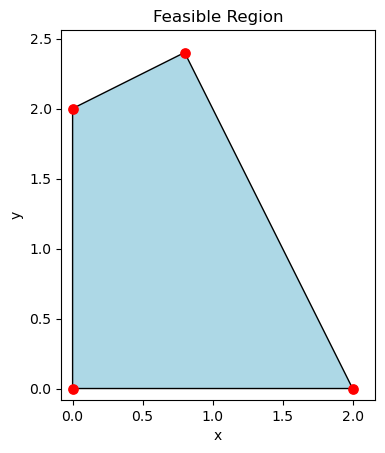

In [36]:
halfspaces = np.array([[2, 1, -4],
                       [-1, 2, -4]])

genFeasibleRegion(halfspaces)

### Example of plotting a feasible region in 3 dimensions

In [37]:
halfspaces = np.array([
                    [1, 1, 1, -10 ],
                    [ 1.,  0.,  0., -4],
                    [ 0.,  1.,  0., -4],
                    [ 0.,  0.,  1., -4],
                    [-1.,  0.,  0.,  0],
                    [ 0., -2.,  0.,  0],
                    [ 0.,  0., -1.,  0]
                    ])
    
genFeasibleRegion(halfspaces)

,Solution,Base
0,"[0.0, 0.0, 0.0, 10.0, 4.0, 4.0, 4.0, 0.0, 0.0,...","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,"[0.0, 0.0, 4.0, 6.0, 4.0, 4.0, 0.0, 0.0, 0.0, ...","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,"[0.0, 0.0, 0.0, 10.0, 4.0, 4.0, 4.0, 0.0, 0.0,...","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
3,"[0.0, 4.0, 0.0, 6.0, 4.0, 0.0, 4.0, 0.0, 8.0, ...","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,"[0.0, 0.0, 0.0, 10.0, 4.0, 4.0, 4.0, 0.0, 0.0,...","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
5,"[0.0, 4.0, 4.0, 2.0, 4.0, 0.0, 0.0, 0.0, 8.0, ...","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
6,"[0.0, 4.0, 0.0, 6.0, 4.0, 0.0, 4.0, 0.0, 8.0, ...","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
7,"[0.0, 0.0, 4.0, 6.0, 4.0, 4.0, 0.0, 0.0, 0.0, ...","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
8,"[0.0, 0.0, 0.0, 10.0, 4.0, 4.0, 4.0, 0.0, 0.0,...","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
9,"[4.0, 0.0, 0.0, 6.0, 0.0, 4.0, 4.0, 4.0, 0.0, ...","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


<Figure size 640x480 with 0 Axes>

# 2) Graphs of different feasible regions


### a)

Feasible region bounded by:

$2x + y \leq 50$ \
$x + 2y \leq 70$ \
$x, y \geq 0$

,Solution,Base
0,"[0.0, 0.0, 50.0, 70.0]","[[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]],..."
1,"[0.0, 35.0, 15.0, 0.0]","[[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]],..."
2,"[25.0, 0.0, 0.0, 45.0]","[[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]],..."
3,"[10.0, 30.0, 0.0, 0.0]","[[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]],..."


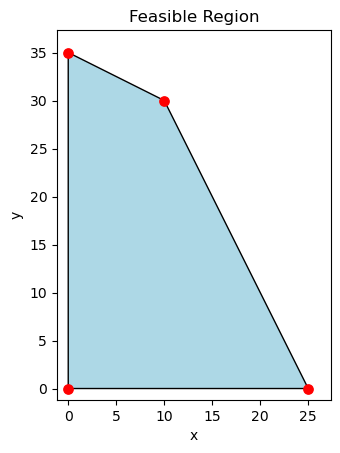

In [38]:
halfspaces = np.array([[2, 1, -50],
                       [1, 2, -70]])

genFeasibleRegion(halfspaces)

### b)
Feasible region bounded by:

$x + y \geq 50$ \
$x \leq 30$ \
$y \leq 40$ \
$x, y \geq 0$

,Solution,Base
0,"[30.0, 20.0, 0.0, 0.0, 20.0]","[[[0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1..."
1,"[10.0, 40.0, 0.0, 20.0, 0.0]","[[[0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1..."
2,"[30.0, 40.0, 20.0, 0.0, 0.0]","[[[0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1..."


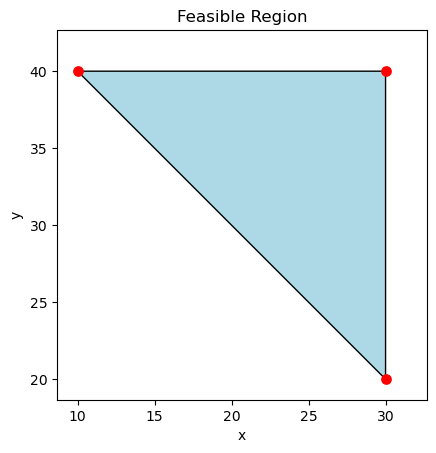

In [39]:
halfspaces = np.array([[-1, -1, 50],
                       [1, 0, -30],
                      [0,1, -40]])

genFeasibleRegion(halfspaces)

### c)
Feasible region bounded by:

$-3x + 2y \leq 6$ \
$5x + 4y \geq 20$ \
$8x + 3y \leq 24$ \
$x, y \geq 0$

,Solution,Base
0,"[0.727, 4.091, 0.0, 0.0, 5.909]","[[[0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1..."
1,"[1.2, 4.8, 0.0, 5.2, 0.0]","[[[0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1..."
2,"[2.118, 2.353, 7.647, 0.0, 0.0]","[[[0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1..."


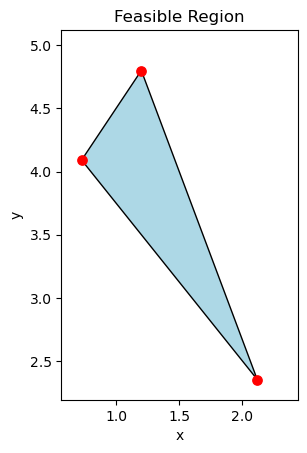

In [40]:
halfspaces = np.array([[-3, 2, -6],
                       [-5, -4, 20],
                      [8,3, -24]])

genFeasibleRegion(halfspaces)

### d)

Feasible region bounded by:

$2x + 3y + 2z \leq 6$ \
$3x - 2z \leq 4$ \
$x, y, z \geq 0$

In [41]:
halfspaces = np.array([[2, 3, 2, -6],
                       [3, 0, -2, -4]])

genFeasibleRegion(halfspaces)

,Solution,Base
0,"[0.0, 0.0, 0.0, 6.0, 4.0]","[[[0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0..."
1,"[0.0, 0.0, 3.0, 0.0, 10.0]","[[[0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0..."
2,"[0.0, 2.0, 0.0, 0.0, 4.0]","[[[0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0..."
3,"[1.333, 0.0, 0.0, 3.333, 0.0]","[[[0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0..."
4,"[2.0, 0.0, 1.0, 0.0, 0.0]","[[[0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0..."
5,"[1.333, 1.111, 0.0, 0.0, 0.0]","[[[0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0..."


One of these four happened: 
 1. The point is not inside the feasible region 
 2. More than three coordinates were written 
 3. Numbers were not written 
 4. Not separated by spaces 


### e)

Feasible region bounded by:

$2x + 3y + 5z \leq 8$ \
$3x - 2y + 2z \leq 4$ \
$2x + y - 3z \leq 6 $ \
$x, y, z \geq 0$

In [42]:
halfspaces = np.array([[2, 3, 5, -8],
                       [3, -2, 2, -4],
                       [2, 1, 3, -6]])

genFeasibleRegion(halfspaces)

,Solution,Base
0,"[0.0, 0.0, 0.0, 8.0, 4.0, 6.0]","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0..."
1,"[0.0, 0.0, 1.6, 0.0, 0.8, 1.2]","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0..."
2,"[0.0, 2.667, 0.0, 0.0, 9.333, 3.333]","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0..."
3,"[1.333, 0.0, 0.0, 5.333, 0.0, 3.333]","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0..."
4,"[0.364, 0.0, 1.455, 0.0, 0.0, 0.909]","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0..."
5,"[2.154, 1.231, 0.0, 0.0, 0.0, 0.462]","[[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0..."


One of these four happened: 
 1. The point is not inside the feasible region 
 2. More than three coordinates were written 
 3. Numbers were not written 
 4. Not separated by spaces 


### f)

Feasible region bounded by:

$2x + y + 2z \leq 12$ \
$x + y - 3z \leq 8$ \
$x, y, z \geq 0$

In [43]:
halfspaces = np.array([[2, 1, 2, -12],
                       [1, 1, -3, -8]])

genFeasibleRegion(halfspaces)

,Solution,Base
0,"[0.0, 0.0, 0.0, 12.0, 8.0]","[[[0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0..."
1,"[0.0, 0.0, 6.0, 0.0, 26.0]","[[[0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0..."
2,"[0.0, 8.0, 0.0, 4.0, 0.0]","[[[0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0..."
3,"[0.0, 10.4, 0.8, 0.0, 0.0]","[[[0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0..."
4,"[6.0, 0.0, 0.0, 0.0, 2.0]","[[[0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0..."
5,"[4.0, 4.0, 0.0, 0.0, 0.0]","[[[0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0..."


One of these four happened: 
 1. The point is not inside the feasible region 
 2. More than three coordinates were written 
 3. Numbers were not written 
 4. Not separated by spaces 


# 3) Using the script found in [scipy.spatial.HalfspaceIntersection](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.HalfspaceIntersection.html) to find the interior point in a 2-dimensional polygon defined from half-spaces. This function was applied to the 2D examples from problem 2.

Below is the implementation for example 2 a)

,Solution,Base
0,"[0.0, 0.0, 50.0, 70.0]","[[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]],..."
1,"[0.0, 35.0, 15.0, 0.0]","[[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]],..."
2,"[25.0, 0.0, 0.0, 45.0]","[[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]],..."
3,"[10.0, 30.0, 0.0, 0.0]","[[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]],..."


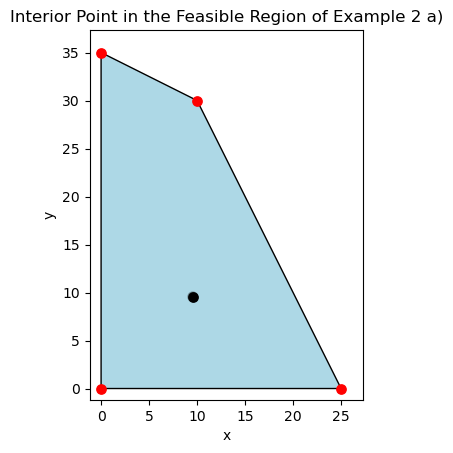

In [44]:
# Define the halfspaces
halfspaces1 = np.array([[2, 1, -50],
                       [1, 2, -70]])

# Carry out a similar process as in the function of point 1. 
b = -1 * halfspaces1[:, -1]
A = np.concatenate((halfspaces1[:, :-1], np.identity(halfspaces1.shape[0])), axis=1)
var2 = fun(A, b)
vertices = []

for item in list(var2['Feasible']):
    lista = list(item)
    vertices.append(lista[:2])

# Define the halfspaces taking into account the x, y >= 0 constraints. 
halfspaces = np.array([[2, 1, -50],
                       [1, 2, -70],
                       [-1, 0, 0],
                       [0, -1, 0]])

# Plot options.
options = {'color': 'lightblue',
           'xlabel': 'x' ,
           'ylabel': 'y',
           'title': 'Interior Point in the Feasible Region of Example 2 a)'}

# Make the 2D plot.
ax = polygon2D(vertices, options)
for item in vertices:
    ax.scatter(item[0], item[1], c='red', marker='.', s=180) 

# Implementation of the script from the example.
norm_vector = np.reshape(np.linalg.norm(halfspaces[:, :-1], axis=1), (halfspaces.shape[0], 1))
c = np.zeros((halfspaces.shape[1],))
c[-1] = -1
A = np.hstack((halfspaces[:, :-1], norm_vector))
b = - halfspaces[:, -1:]

# Find the interior point of the feasible region plotted above using the linprog function
res = linprog(c, A_ub=A, b_ub=b, bounds=(None, None))
x = res.x[:-1]

# Create a circle at the optimal solution returned by the linprog function.
circle = Circle(x, radius=0.5, alpha=0.3, color='black')
ax.add_patch(circle) 
ax.scatter(x[0], x[1], c='black', marker='.', s=180)


Below is the implementation for example 2 b)

,Solution,Base
0,"[30.0, 20.0, 0.0, 0.0, 20.0]","[[[0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1..."
1,"[10.0, 40.0, 0.0, 20.0, 0.0]","[[[0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1..."
2,"[30.0, 40.0, 20.0, 0.0, 0.0]","[[[0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1..."


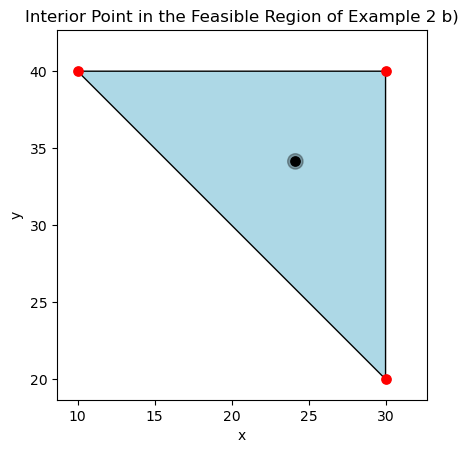

In [45]:
# Define the halfspaces
halfspaces1 = np.array([[-1, -1, 50],
                       [1, 0, -30],
                      [0, 1, -40]])

# Define the halfspaces taking into account the x, y >= 0 constraints. 
halfspaces = np.array([[-1., -1., 50],
                       [1., 0, -30.], 
                       [0., 1, -40],
                       [-1, 0, 0],
                       [0, -1, 0]])

# Carry out a similar process as in the function of point 1. 
b = -1 * halfspaces1[:, -1]
A = np.concatenate((halfspaces1[:, :-1], np.identity(halfspaces1.shape[0])), axis=1)
var2 = fun(A, b)
vertices = []

for item in list(var2['Feasible']):
    lista = list(item)
    vertices.append(lista[:2])

options = {'color': 'lightblue',
           'xlabel': 'x' ,
           'ylabel': 'y',
           'title': 'Interior Point in the Feasible Region of Example 2 b)'}

# Draw shape from the points
ax = polygon2D(vertices, options)
for item in vertices:
    ax.scatter(item[0], item[1], c='red', marker='.', s=180)

# Implementation of the script from the example.
norm_vector = np.reshape(np.linalg.norm(halfspaces[:, :-1], axis=1), (halfspaces.shape[0], 1))
c = np.zeros((halfspaces.shape[1],))
c[-1] = -1
A = np.hstack((halfspaces[:, :-1], norm_vector))
b = - halfspaces[:, -1:]

# Find the interior point of the feasible region plotted above using the linprog function
res = linprog(c, A_ub=A, b_ub=b, bounds=(None, None))
x = res.x[:-1]

# Create a circle at the optimal solution returned by the linprog function.
circle = Circle(x, radius=0.5, alpha=0.3, color='black')
ax.add_patch(circle) 
ax.scatter(x[0], x[1], c='black', marker='.', s=180)


Below is the implementation for example 2 c)

,Solution,Base
0,"[0.727, 4.091, 0.0, 0.0, 5.909]","[[[0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1..."
1,"[1.2, 4.8, 0.0, 5.2, 0.0]","[[[0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1..."
2,"[2.118, 2.353, 7.647, 0.0, 0.0]","[[[0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1..."


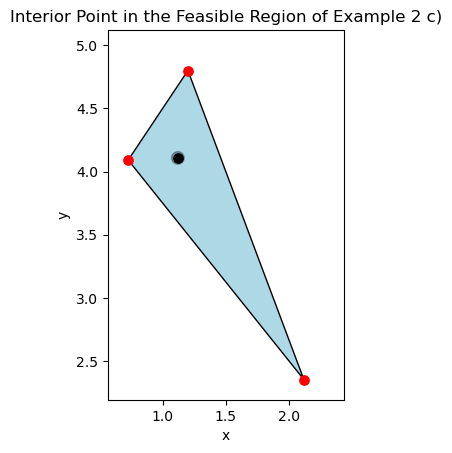

In [46]:
# Define the halfspaces
halfspaces1 = np.array([[-3, 2, -6],
                       [-5, -4, 20],
                      [8,3, -24]])

# Define the halfspaces taking into account the x, y >= 0 constraints. 
halfspaces = np.array([[-3., 2., -6],
                       [-5., -4, 20.],
                       [8, 3, -24],
                       [-1, 0, 0],
                       [0, -1, 0]])

# Carry out a similar process as in the function of point 1. 
b = -1 * halfspaces1[:, -1]
A = np.concatenate((halfspaces1[:, :-1], np.identity(halfspaces1.shape[0])), axis=1)
var2 = fun(A, b)
vertices = []

for item in list(var2['Feasible']):
    lista = list(item)
    vertices.append(lista[:2])

options = {'color': 'lightblue',
           'xlabel': 'x' ,
           'ylabel': 'y',
           'title': 'Interior Point in the Feasible Region of Example 2 c)'}

# Draw shape from the points
ax = polygon2D(vertices, options)
for item in vertices:
    ax.scatter(item[0], item[1], c='red', marker='.', s=180)

# Implementation of the script from the example.
norm_vector = np.reshape(np.linalg.norm(halfspaces[:, :-1], axis=1), (halfspaces.shape[0], 1))
c = np.zeros((halfspaces.shape[1],))
c[-1] = -1
A = np.hstack((halfspaces[:, :-1], norm_vector))
b = - halfspaces[:, -1:]

# Find the interior point of the feasible region plotted above using the linprog function
res = linprog(c, A_ub=A, b_ub=b, bounds=(None, None))
x = res.x[:-1]

# Create a circle at the optimal solution returned by the linprog function.
circle = Circle(x, radius=0.05, alpha=0.3, color='black')
ax.add_patch(circle) 
ax.scatter(x[0], x[1], c='black', marker='.', s=180)